In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error,accuracy_score

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

### 1. Basic Data Claening and Splitting data

In [2]:
data = pd.read_csv('car_insurance_claim.csv')
data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [3]:
data_df = data.copy()

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   BIRTH       10302 non-null  object 
 3   AGE         10295 non-null  float64
 4   HOMEKIDS    10302 non-null  int64  
 5   YOJ         9754 non-null   float64
 6   INCOME      9732 non-null   object 
 7   PARENT1     10302 non-null  object 
 8   HOME_VAL    9727 non-null   object 
 9   MSTATUS     10302 non-null  object 
 10  GENDER      10302 non-null  object 
 11  EDUCATION   10302 non-null  object 
 12  OCCUPATION  9637 non-null   object 
 13  TRAVTIME    10302 non-null  int64  
 14  CAR_USE     10302 non-null  object 
 15  BLUEBOOK    10302 non-null  object 
 16  TIF         10302 non-null  int64  
 17  CAR_TYPE    10302 non-null  object 
 18  RED_CAR     10302 non-null  object 
 19  OLDCLAIM    10302 non-nul

In [5]:
data_df.duplicated().sum()

1

In [6]:
data_df.drop_duplicates(inplace=True)

In [7]:
currency_col = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM','CLM_AMT']
for col in currency_col:
    data_df[col] = data_df[col].replace('[\\$,]', '', regex=True).astype('Int64')

In [8]:
prefix_col = ['MSTATUS','GENDER','EDUCATION','OCCUPATION','CAR_TYPE','URBANICITY']
for col in prefix_col:
    data_df[col] = data_df[col].str.replace('z_','')


In [9]:
data_df.drop(columns=['ID','BIRTH'],inplace=True)

<Axes: xlabel='CLM_AMT', ylabel='Count'>

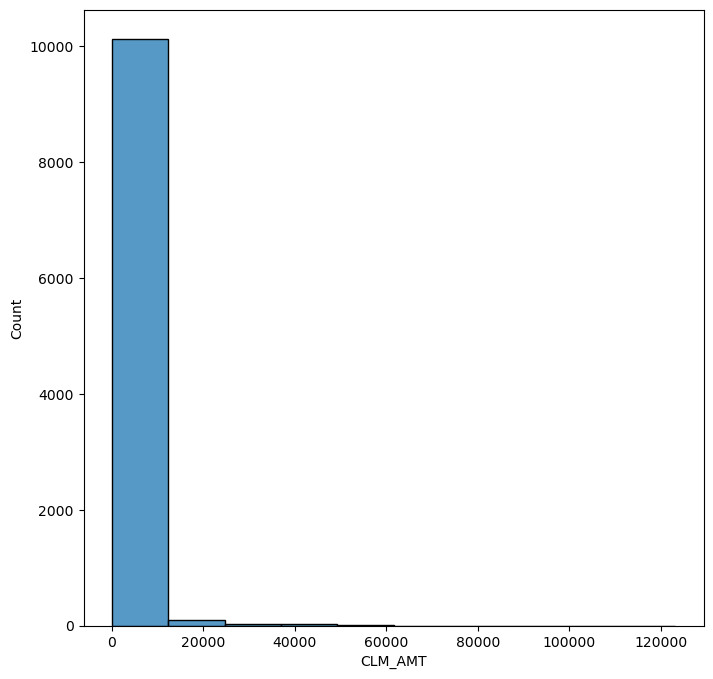

In [10]:
plt.figure(figsize=(8,8))
sns.histplot(data_df['CLM_AMT'],bins=10)

<Axes: ylabel='cat_claim_amt'>

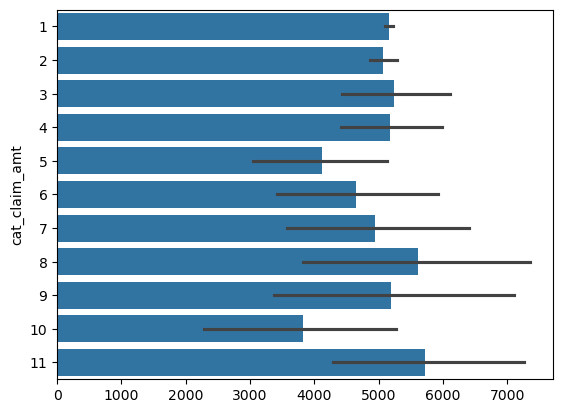

In [11]:
bins = [0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,np.inf]
labels = np.arange(1,12)
data_df['cat_claim_amt'] = pd.cut(data_df['CLM_AMT'],bins=bins,labels=labels,include_lowest=True)
sns.barplot(data_df['cat_claim_amt'])

In [12]:
data_df

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY,cat_claim_amt
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,...,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban,1
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,...,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban,1
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,...,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban,1
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,...,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban,1
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,...,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,1,45.0,2,9.0,164669,No,386273,Yes,M,PhD,...,no,0,0,No,2,0,17.0,0,Highly Urban/ Urban,1
10298,0,46.0,0,9.0,107204,No,332591,Yes,M,Masters,...,no,0,0,No,0,0,1.0,0,Highly Urban/ Urban,1
10299,0,48.0,0,15.0,39837,No,170611,Yes,F,<High School,...,no,0,0,No,0,0,1.0,0,Highly Urban/ Urban,1
10300,0,50.0,0,7.0,43445,No,149248,Yes,F,Bachelors,...,no,0,0,No,0,0,11.0,0,Highly Urban/ Urban,1


In [13]:
X = data_df.copy()
y = data_df['CLAIM_FLAG']

X.drop(columns=['CLAIM_FLAG','CLM_AMT'],inplace=True)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=X['cat_claim_amt'])

In [15]:
for temp in (X_test,X_train):
    temp.drop(columns=['cat_claim_amt'],inplace=True)

# Exploatary Data Analysis(EDA)

In [16]:
eda_data = X_train.copy()
eda_data['CLAIM_FLAG'] = y_train

In [17]:
binary_col = ['PARENT1','MSTATUS','GENDER','RED_CAR','REVOKED']
mapping  = {
    'Yes':1,
    'No':0,
    'yes':1,
    'no':0,
    'M':1,
    'F':0
}

for col in binary_col:
    eda_data[col] = eda_data[col].map(mapping)

In [18]:
eda_data

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,CLAIM_FLAG
9287,0,46.0,0,0.0,0,0,59722,1,0,Bachelors,...,1,SUV,0,0,0,0,1,9.0,Highly Rural/ Rural,0
5292,0,55.0,0,8.0,86574,0,323469,1,1,Masters,...,3,Van,1,0,0,0,0,18.0,Highly Urban/ Urban,1
2119,0,46.0,0,13.0,65075,0,0,0,0,Bachelors,...,1,SUV,0,5219,3,0,5,11.0,Highly Urban/ Urban,1
3236,0,46.0,0,6.0,90232,0,260661,0,0,Bachelors,...,1,SUV,0,0,0,0,1,14.0,Highly Urban/ Urban,0
1432,0,47.0,0,0.0,0,0,0,0,1,Bachelors,...,1,Minivan,1,0,0,0,0,14.0,Highly Urban/ Urban,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,0,28.0,1,9.0,20852,0,123109,1,0,High School,...,1,Sports Car,0,8413,2,0,3,1.0,Highly Urban/ Urban,1
1879,0,47.0,0,NaN,167760,0,0,0,1,PhD,...,1,Panel Truck,1,0,0,0,0,17.0,Highly Urban/ Urban,0
6097,0,35.0,2,10.0,86997,0,234307,1,0,Masters,...,1,Pickup,0,6459,3,0,4,16.0,Highly Urban/ Urban,0
7243,0,25.0,1,10.0,35714,1,0,0,1,<High School,...,3,Minivan,1,2083,3,0,6,1.0,Highly Urban/ Urban,1


In [19]:
eda_data.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,CLAIM_FLAG
9287,0,46.0,0,0.0,0,0,59722,1,0,Bachelors,...,1,SUV,0,0,0,0,1,9.0,Highly Rural/ Rural,0
5292,0,55.0,0,8.0,86574,0,323469,1,1,Masters,...,3,Van,1,0,0,0,0,18.0,Highly Urban/ Urban,1
2119,0,46.0,0,13.0,65075,0,0,0,0,Bachelors,...,1,SUV,0,5219,3,0,5,11.0,Highly Urban/ Urban,1
3236,0,46.0,0,6.0,90232,0,260661,0,0,Bachelors,...,1,SUV,0,0,0,0,1,14.0,Highly Urban/ Urban,0
1432,0,47.0,0,0.0,0,0,0,0,1,Bachelors,...,1,Minivan,1,0,0,0,0,14.0,Highly Urban/ Urban,0


In [20]:
eda_data.corr(numeric_only=True)

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,TRAVTIME,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,CLAIM_FLAG
KIDSDRIV,1.000000,-0.082935,0.463567,0.041405,-0.043234,0.212565,-0.016940,0.033139,-0.037883,0.018484,-0.029516,-0.004167,-0.040811,0.027244,0.042724,0.031013,0.056608,-0.067156,0.094662
AGE,-0.082935,1.000000,-0.454711,0.141620,0.178316,-0.315483,0.200327,0.087470,0.061066,0.000428,0.160973,-0.005520,0.019310,-0.036370,-0.033375,-0.040160,-0.077345,0.174373,-0.097878
HOMEKIDS,0.463567,-0.454711,1.000000,0.078948,-0.155189,0.454699,-0.108981,0.043409,-0.110340,-0.004172,-0.109928,0.007679,-0.069694,0.036508,0.044859,0.040998,0.072808,-0.164184,0.114188
YOJ,0.041405,0.141620,0.078948,1.000000,0.290319,-0.032355,0.263991,0.131804,0.083513,-0.009850,0.145140,0.024458,0.057472,0.002754,-0.013578,-0.003023,-0.037522,0.058601,-0.068262
INCOME,-0.043234,0.178316,-0.155189,0.290319,1.000000,-0.055528,0.581062,-0.043648,0.116411,-0.040310,0.426477,0.003697,0.070725,-0.049270,-0.053197,-0.023170,-0.065010,0.419484,-0.138388
PARENT1,0.212565,-0.315483,0.454699,-0.032355,-0.055528,1.000000,-0.250712,-0.475956,-0.065237,-0.014566,-0.048128,0.006236,-0.041670,0.037728,0.064590,0.049638,0.075993,-0.070808,0.153830
HOME_VAL,-0.016940,0.200327,-0.108981,0.263991,0.581062,-0.250712,1.000000,0.450632,0.076811,-0.026467,0.262423,0.007689,0.033037,-0.054205,-0.087463,-0.041056,-0.089753,0.226423,-0.177642
MSTATUS,0.033139,0.087470,0.043409,0.131804,-0.043648,-0.475956,0.450632,1.000000,-0.007241,-0.002928,-0.002852,-0.002983,-0.018954,-0.033958,-0.061897,-0.043548,-0.042892,-0.038423,-0.129316
GENDER,-0.037883,0.061066,-0.110340,0.083513,0.116411,-0.065237,0.076811,-0.007241,1.000000,-0.007165,0.063541,-0.004584,0.662216,-0.007601,0.013866,-0.005404,-0.005150,0.025904,-0.006881
TRAVTIME,0.018484,0.000428,-0.004172,-0.009850,-0.040310,-0.014566,-0.026467,-0.002928,-0.007165,1.000000,-0.027194,-0.016534,0.009756,-0.016085,0.010183,-0.005574,0.013947,-0.022619,0.044436


<Axes: >

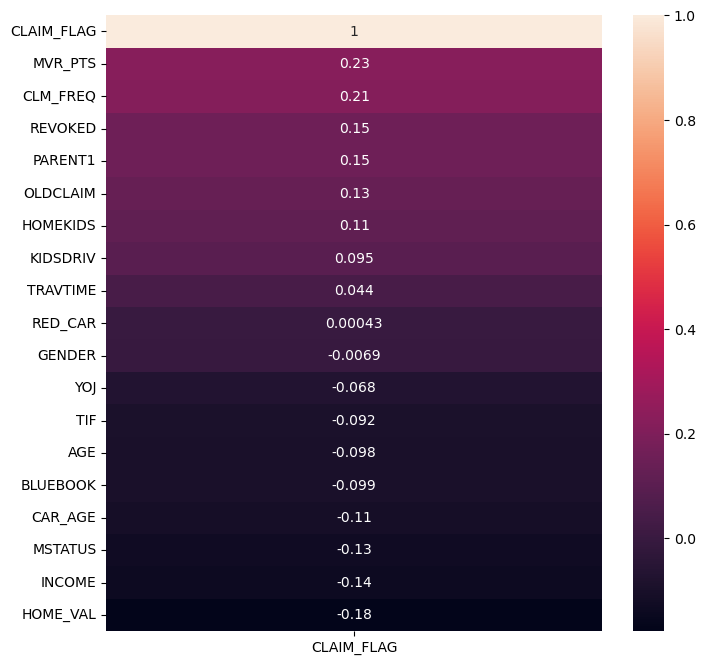

In [21]:
corr_metrix = eda_data.corr(numeric_only=True).sort_values(by=['CLAIM_FLAG'],ascending=False)
fig, ax=plt.subplots(figsize=(8,8))
sns.heatmap(corr_metrix[['CLAIM_FLAG']],annot=True,)


# Data Cleaning 

In [22]:
X_train_raw = X_train.copy()
col_to_drop = ['RED_CAR']
X_train_raw.drop(columns=col_to_drop,inplace=True)


In [23]:
X_train_raw.isna().sum()

KIDSDRIV        0
AGE             5
HOMEKIDS        0
YOJ           433
INCOME        442
PARENT1         0
HOME_VAL      469
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION    513
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CAR_AGE       521
URBANICITY      0
dtype: int64

In [24]:
num_col = X_train_raw.select_dtypes('number').columns.values
cat_col = X_train_raw.select_dtypes('object').columns.values



In [25]:
knn_imputer = KNNImputer(n_neighbors=5)

def knn_num(data,cols,imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data),columns=data.columns)
    return data_imputed

num_data_imputed = knn_num(X_train_raw,num_col,knn_imputer)
num_data_imputed.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
0,0.0,46.0,0.0,0.0,0.0,59722.0,54.0,6140.0,1.0,0.0,0.0,1.0,9.0
1,0.0,55.0,0.0,8.0,86574.0,323469.0,47.0,17020.0,3.0,0.0,0.0,0.0,18.0
2,0.0,46.0,0.0,13.0,65075.0,0.0,33.0,12610.0,1.0,5219.0,3.0,5.0,11.0
3,0.0,46.0,0.0,6.0,90232.0,260661.0,42.0,15780.0,1.0,0.0,0.0,1.0,14.0
4,0.0,47.0,0.0,0.0,0.0,0.0,25.0,12030.0,1.0,0.0,0.0,0.0,14.0


In [26]:
simple_imputer = SimpleImputer(strategy='most_frequent')

def simple_cat(data,cols,imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data),columns=data.columns)
    return data_imputed

cat_data_imputed = simple_cat(X_train_raw,cat_col,simple_imputer)
cat_data_imputed.head()

,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,REVOKED,URBANICITY
0,No,Yes,F,Bachelors,Home Maker,Private,SUV,No,Highly Rural/ Rural
1,No,Yes,M,Masters,Manager,Private,Van,No,Highly Urban/ Urban
2,No,No,F,Bachelors,Professional,Private,SUV,No,Highly Urban/ Urban
3,No,No,F,Bachelors,Professional,Private,SUV,No,Highly Urban/ Urban
4,No,No,M,Bachelors,Student,Commercial,Minivan,No,Highly Urban/ Urban


In [27]:
X_train_imputed = pd.concat([num_data_imputed,cat_data_imputed],axis=1)
X_train_imputed.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,...,CAR_AGE,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,REVOKED,URBANICITY
0,0.0,46.0,0.0,0.0,0.0,59722.0,54.0,6140.0,1.0,0.0,...,9.0,No,Yes,F,Bachelors,Home Maker,Private,SUV,No,Highly Rural/ Rural
1,0.0,55.0,0.0,8.0,86574.0,323469.0,47.0,17020.0,3.0,0.0,...,18.0,No,Yes,M,Masters,Manager,Private,Van,No,Highly Urban/ Urban
2,0.0,46.0,0.0,13.0,65075.0,0.0,33.0,12610.0,1.0,5219.0,...,11.0,No,No,F,Bachelors,Professional,Private,SUV,No,Highly Urban/ Urban
3,0.0,46.0,0.0,6.0,90232.0,260661.0,42.0,15780.0,1.0,0.0,...,14.0,No,No,F,Bachelors,Professional,Private,SUV,No,Highly Urban/ Urban
4,0.0,47.0,0.0,0.0,0.0,0.0,25.0,12030.0,1.0,0.0,...,14.0,No,No,M,Bachelors,Student,Commercial,Minivan,No,Highly Urban/ Urban


In [28]:
X_train_imputed.isna().sum()

KIDSDRIV      0
AGE           0
HOMEKIDS      0
YOJ           0
INCOME        0
HOME_VAL      0
TRAVTIME      0
BLUEBOOK      0
TIF           0
OLDCLAIM      0
CLM_FREQ      0
MVR_PTS       0
CAR_AGE       0
PARENT1       0
MSTATUS       0
GENDER        0
EDUCATION     0
OCCUPATION    0
CAR_USE       0
CAR_TYPE      0
REVOKED       0
URBANICITY    0
dtype: int64

In [29]:
cat_data_imputed.nunique()

PARENT1       2
MSTATUS       2
GENDER        2
EDUCATION     5
OCCUPATION    8
CAR_USE       2
CAR_TYPE      6
REVOKED       2
URBANICITY    2
dtype: int64

In [30]:
cat_col_order = ['EDUCATION']
cat_col_binary = ['PARENT1','MSTATUS','GENDER','CAR_USE','REVOKED','URBANICITY']
cat_col_onehot = ['CAR_TYPE','OCCUPATION']

In [31]:
categories = [['<High School','High School','Bachelors','Masters','PhD']]
encoder_ord = OrdinalEncoder(categories=categories)
cat_ordered_df = pd.DataFrame(encoder_ord.fit_transform(cat_data_imputed[cat_col_order]),columns=cat_col_order)

In [32]:
encoder_bin = OrdinalEncoder()
cat_binary_df = pd.DataFrame(encoder_bin.fit_transform(cat_data_imputed[cat_col_binary]),columns=cat_col_binary)

In [33]:
encoder_onehot = OneHotEncoder(handle_unknown='ignore',sparse_output=False,drop='first')
cat_onehot_df = pd.DataFrame(encoder_onehot.fit_transform(cat_data_imputed[cat_col_onehot]),columns = encoder_onehot.get_feature_names_out())

In [34]:
cat_data_encoded = pd.concat([cat_binary_df,cat_ordered_df,cat_onehot_df],axis=1)
cat_data_encoded.head()

,PARENT1,MSTATUS,GENDER,CAR_USE,REVOKED,URBANICITY,EDUCATION,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_SUV,CAR_TYPE_Sports Car,CAR_TYPE_Van,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student
0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
X_train_cleaned = pd.concat([num_data_imputed,cat_data_encoded],axis=1)
X_train_cleaned.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,...,CAR_TYPE_SUV,CAR_TYPE_Sports Car,CAR_TYPE_Van,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student
0,0.0,46.0,0.0,0.0,0.0,59722.0,54.0,6140.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,55.0,0.0,8.0,86574.0,323469.0,47.0,17020.0,3.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,46.0,0.0,13.0,65075.0,0.0,33.0,12610.0,1.0,5219.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,46.0,0.0,6.0,90232.0,260661.0,42.0,15780.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,47.0,0.0,0.0,0.0,0.0,25.0,12030.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Model Selection

In [36]:
models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=1000, dual='auto')),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
]

In [37]:
results ={}

for model_name,model in models:
    cv_score = cross_val_score(model,X_train_cleaned,y_train,cv=10)
    results[model_name] = cv_score

cv_score_df = pd.DataFrame(results)



In [38]:
cv_score_df

,Logistic Regression,KNN,Decision Tree,Random Forest,Linear SVM,XGBoost,AdaBoost,Gradient Boost,Bagging,CatBoost
0,0.736650,0.719660,0.713592,0.776699,0.736650,0.771845,0.776699,0.799757,0.750000,0.790049
1,0.724515,0.713592,0.679612,0.766990,0.730583,0.745146,0.756068,0.771845,0.737864,0.763350
2,0.735437,0.703883,0.711165,0.770631,0.730583,0.765777,0.777913,0.793689,0.753641,0.788835
3,0.743932,0.705097,0.701456,0.782767,0.745146,0.777913,0.781553,0.794903,0.769417,0.796117
4,0.728155,0.707524,0.713592,0.780340,0.729369,0.770631,0.766990,0.796117,0.759709,0.800971
5,0.729369,0.723301,0.686893,0.792476,0.731796,0.771845,0.779126,0.788835,0.768204,0.811893
6,0.741505,0.706311,0.707524,0.794903,0.734223,0.780340,0.792476,0.803398,0.756068,0.804612
7,0.733010,0.717233,0.678398,0.786408,0.728155,0.779126,0.786408,0.798544,0.788835,0.798544
8,0.731796,0.697816,0.706311,0.787621,0.735437,0.786408,0.788835,0.792476,0.770631,0.804612
9,0.737864,0.711165,0.689320,0.768204,0.735437,0.758495,0.786408,0.776699,0.751214,0.773058


Text(0.5, 1.0, 'Cross-Validation Score for Different Classifiers')

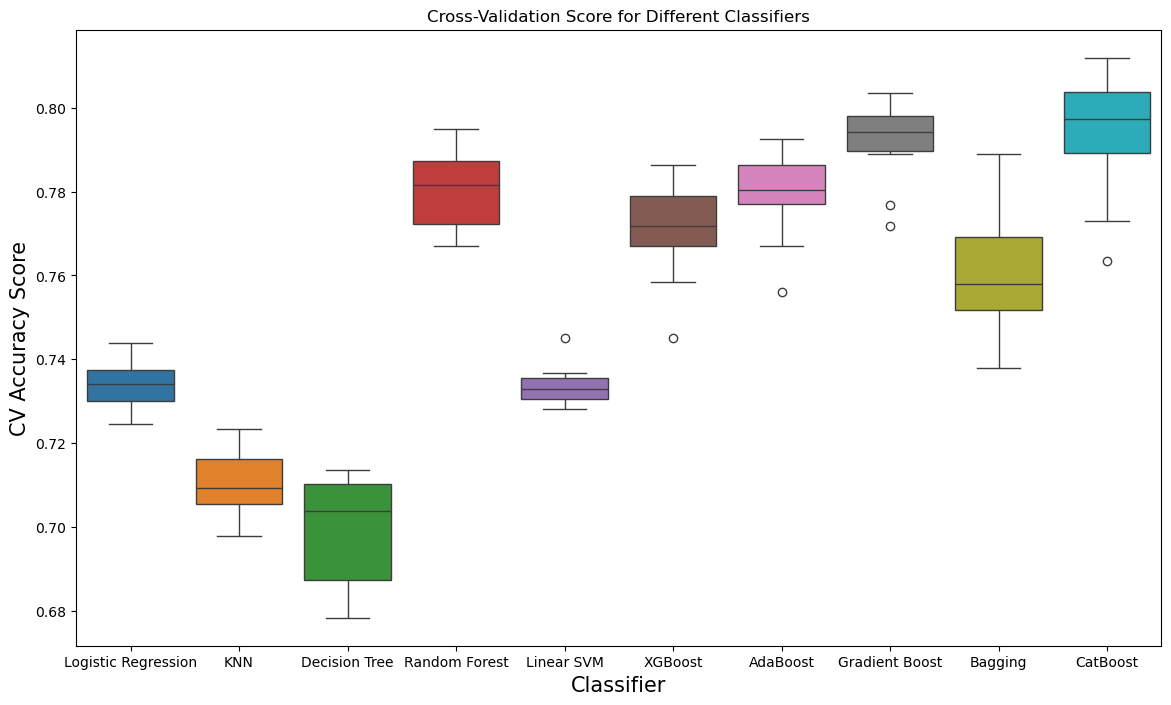

In [39]:
fig, ax=plt.subplots(figsize=(14,8))
sns.boxplot(cv_score_df)
ax.set_xlabel('Classifier',fontsize=15)
ax.set_ylabel('CV Accuracy Score',fontsize=15)
ax.set_title('Cross-Validation Score for Different Classifiers')

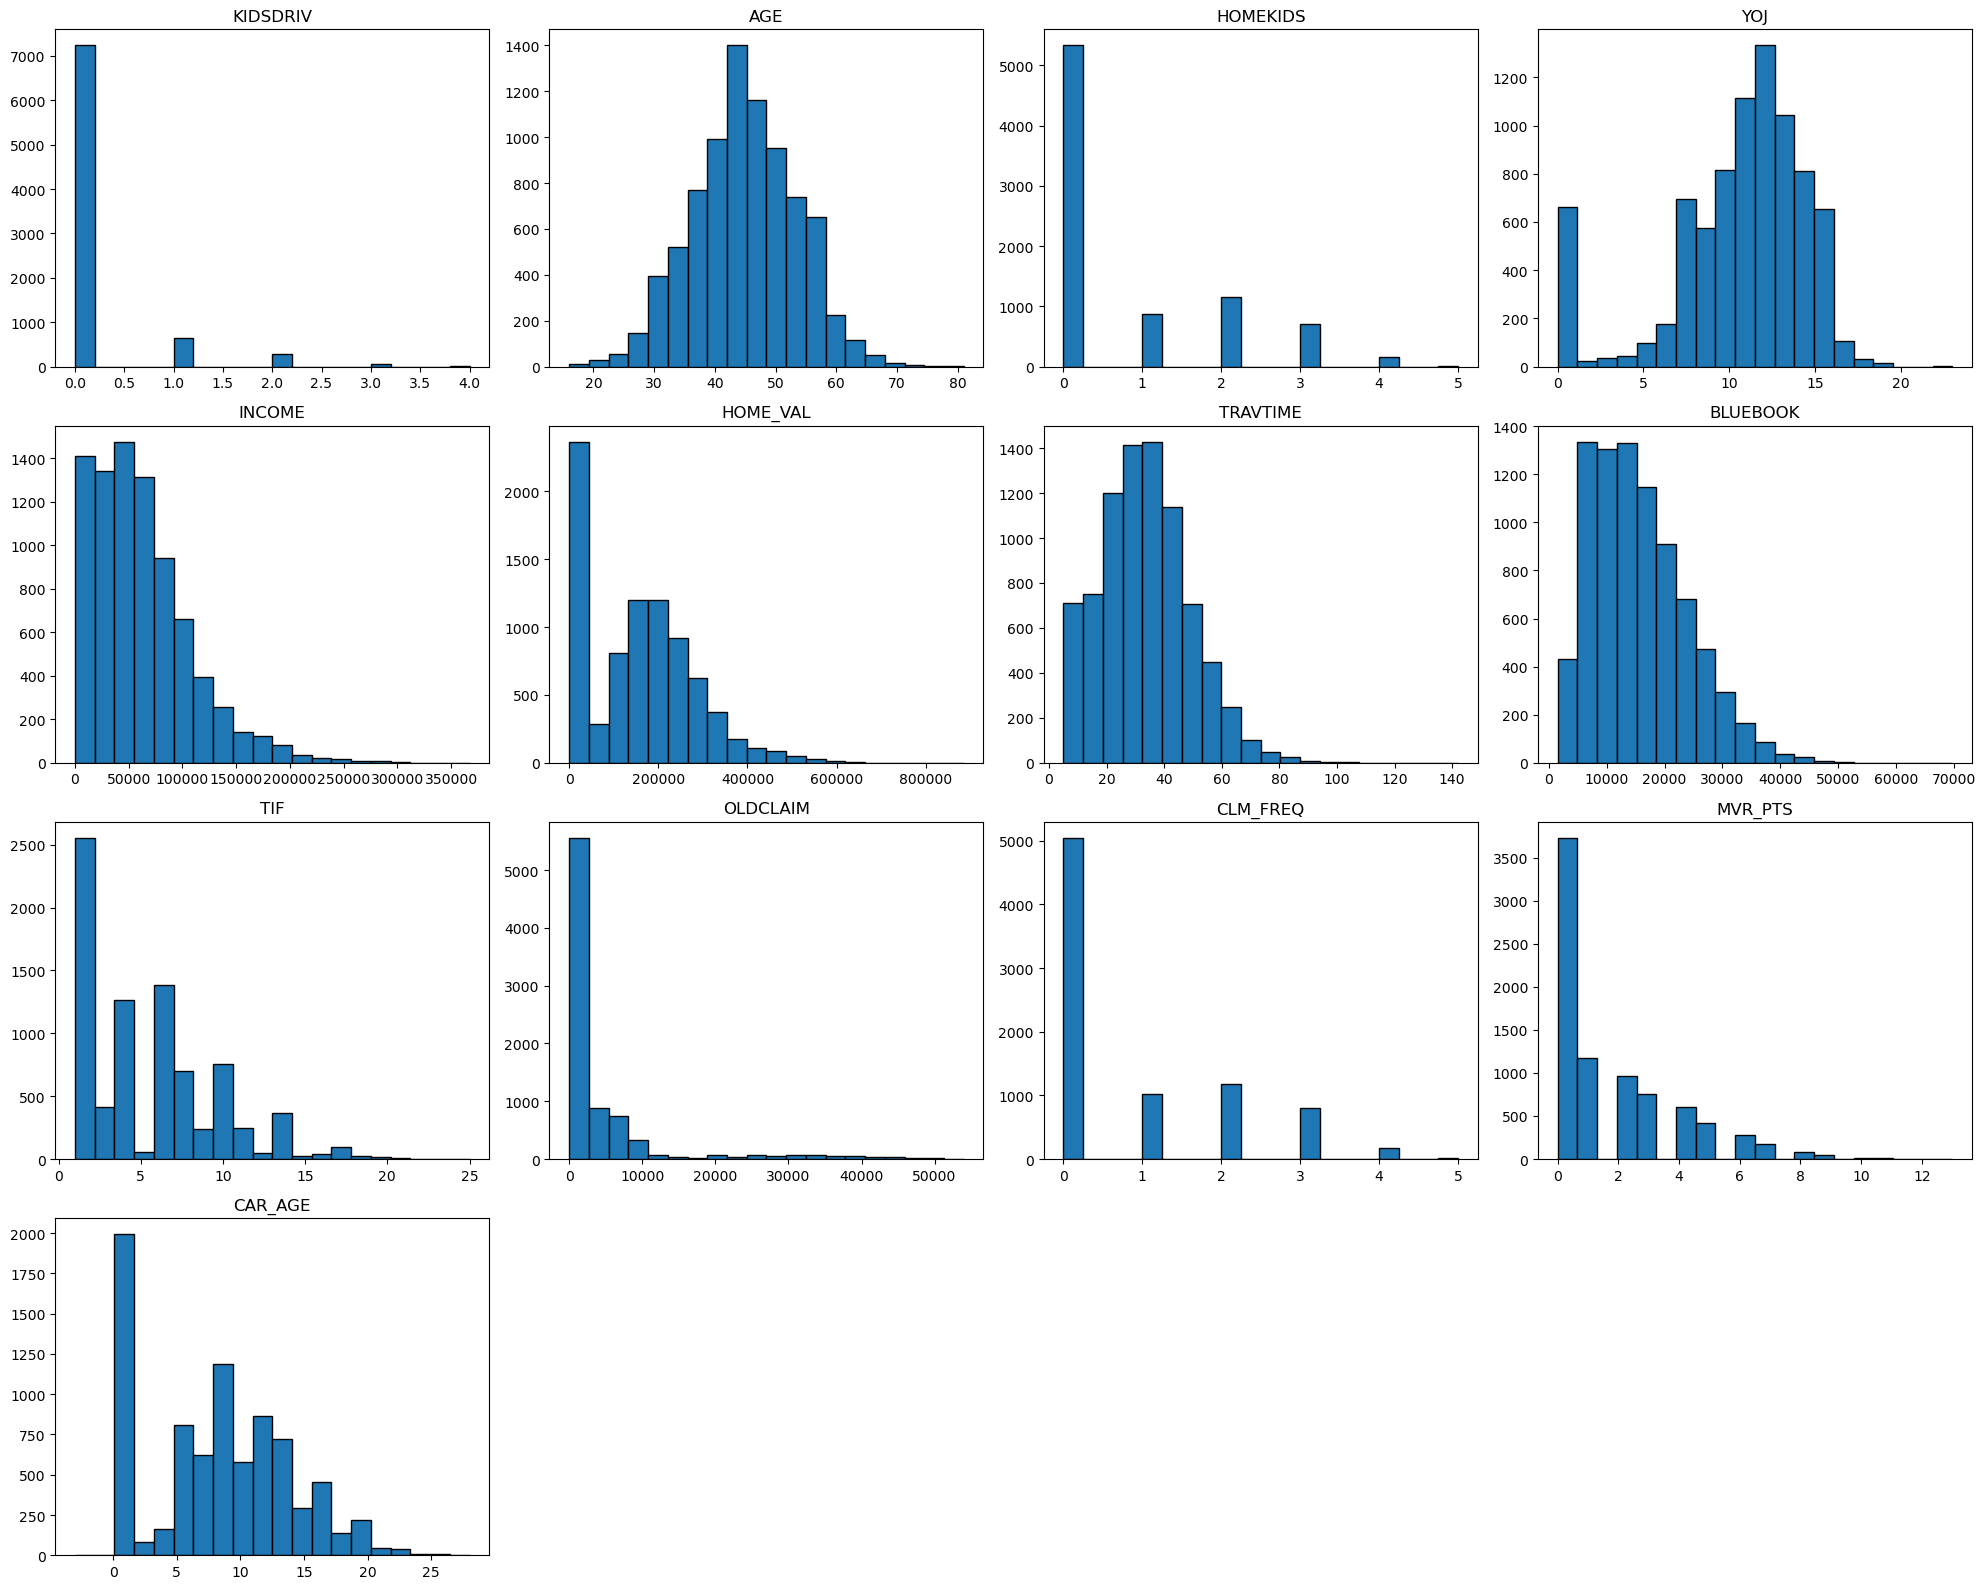

In [40]:
fig, ax = plt.subplots(4,4,figsize=(20,16))
ax = ax.flatten()

for i,col in enumerate(num_col):
    ax[i].hist(X_train_cleaned[col],bins=20,edgecolor='black')
    ax[i].set_title(col)

for j in range(len(num_col),len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [41]:
skew_col = ['INCOME','HOME_VAL','TRAVTIME','BLUEBOOK','TIF','MVR_PTS']

def log_feature(dataset,skewed_feature):
    data=dataset.copy()
    for col in skewed_feature:
        data[col] = np.sqrt(data[col])
    return data

X_train_cleaned_log = log_feature(X_train_cleaned,skew_col)

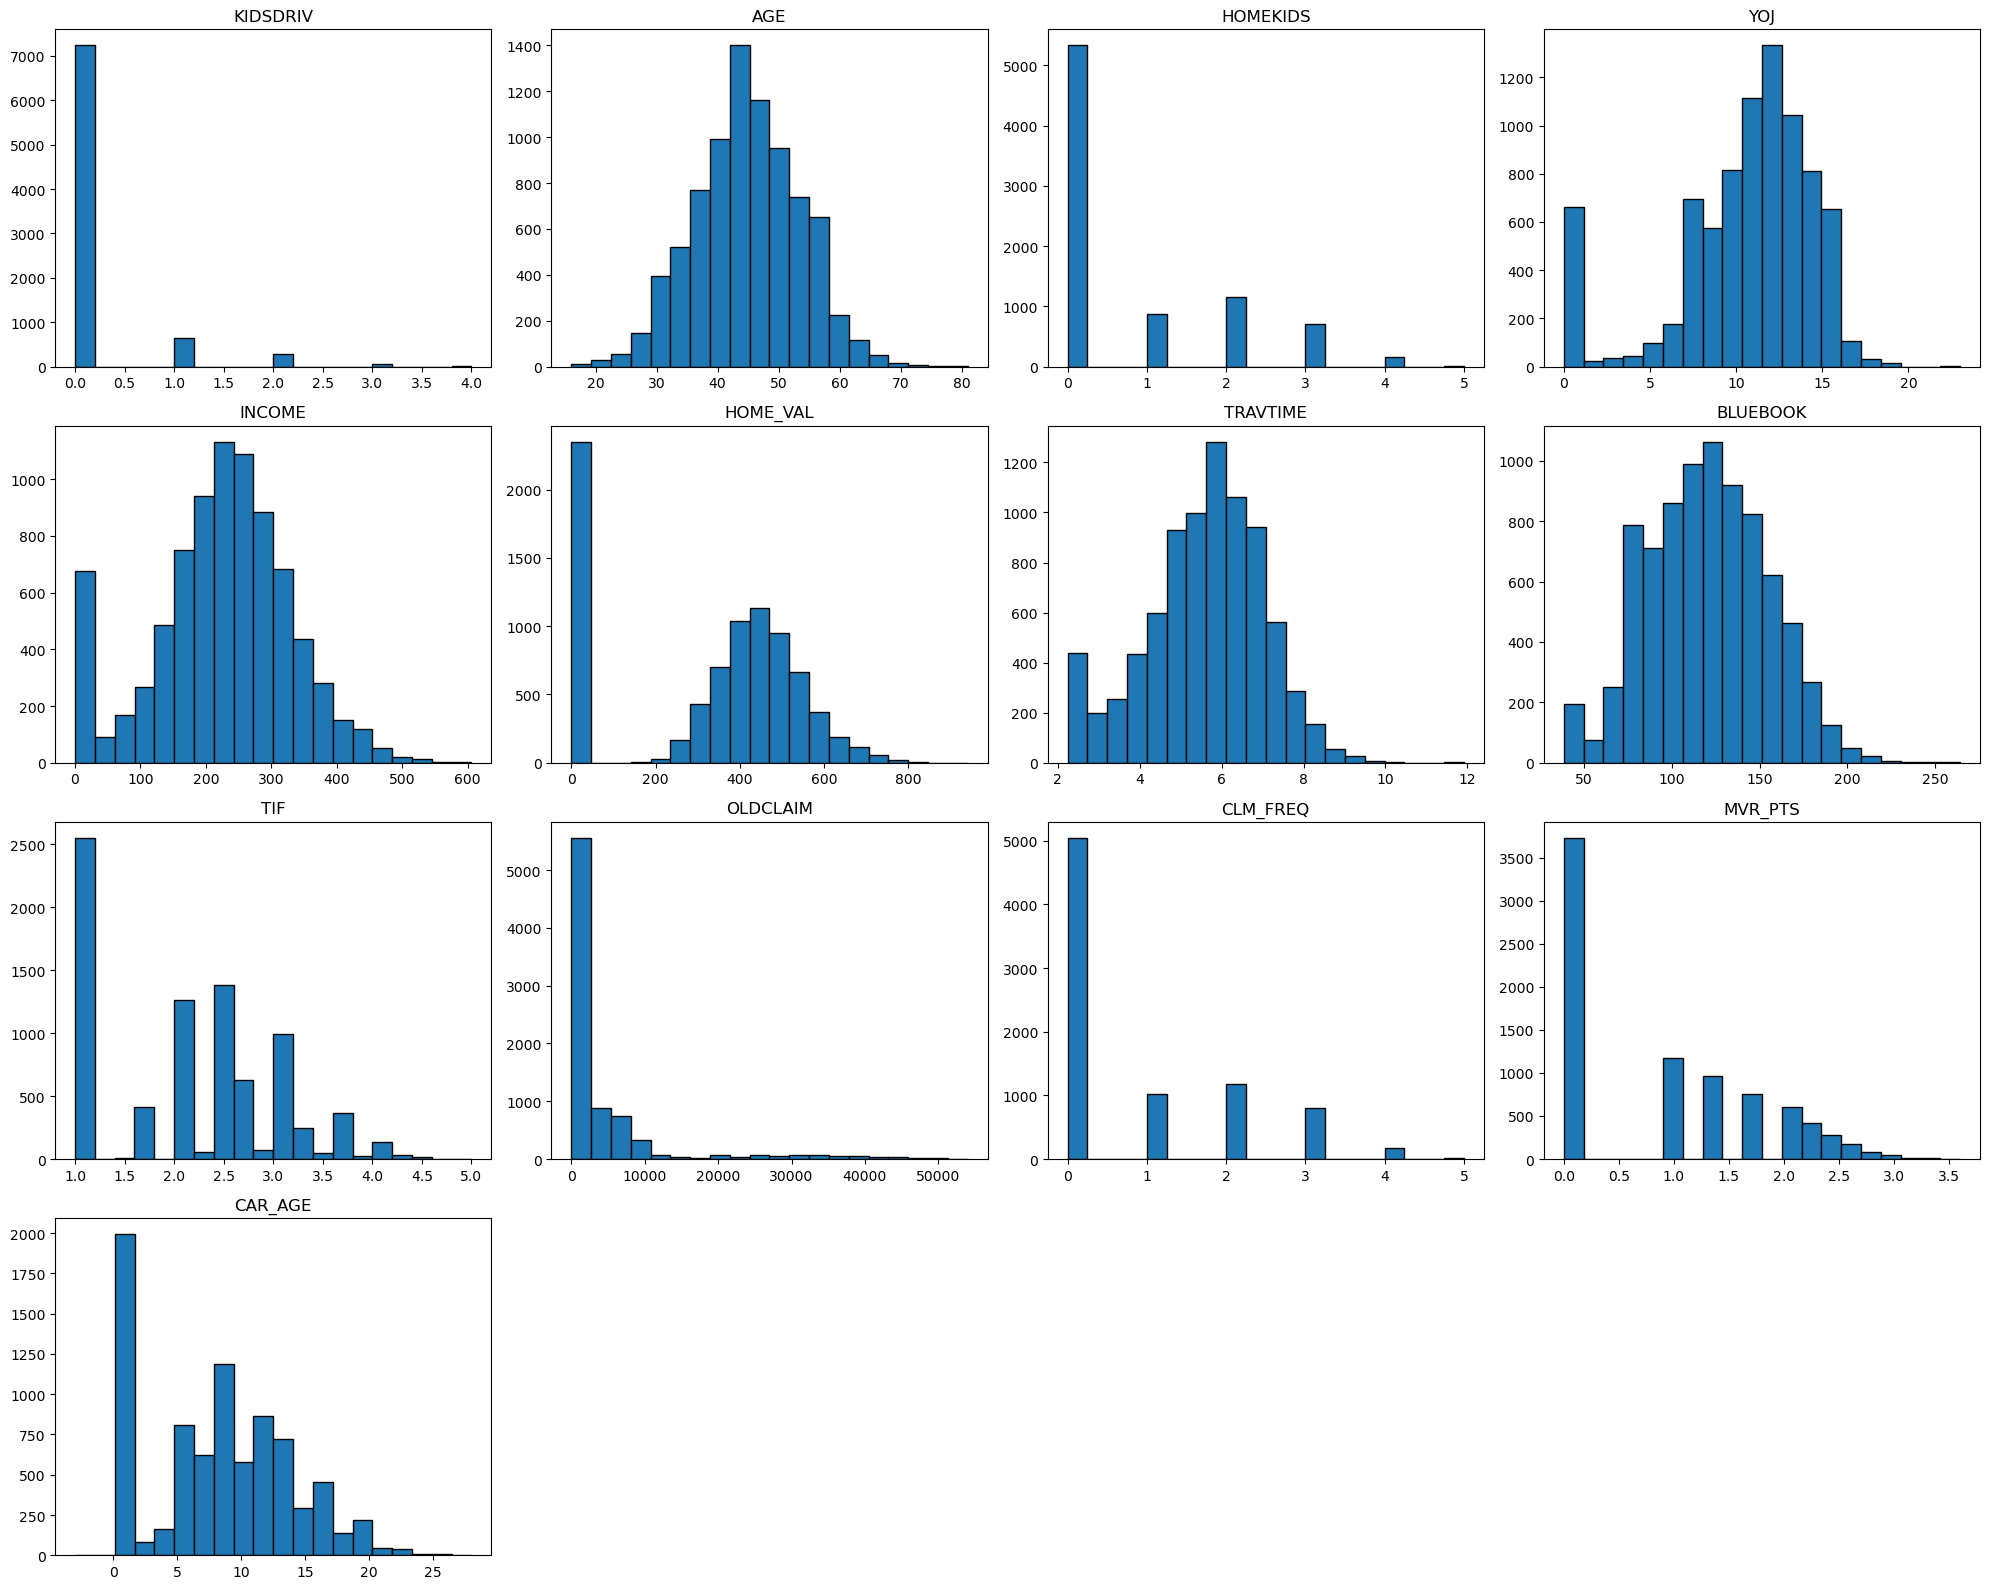

In [42]:
fig, ax = plt.subplots(4,4,figsize=(20,16))
ax = ax.flatten()

for i,col in enumerate(num_col):
    ax[i].hist(X_train_cleaned_log[col],bins=20,edgecolor='black')
    ax[i].set_title(col)

for j in range(len(num_col),len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [43]:
scaler = StandardScaler()
def scale(data,num_col):
    data=data.copy()
    data[num_col] = pd.DataFrame(scaler.fit_transform(data[num_col]),columns=data[num_col].columns)
    return data
X_train_cleaned_scaled = scale(X_train_cleaned_log,num_col)
X_train_cleaned_scaled

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,...,CAR_TYPE_SUV,CAR_TYPE_Sports Car,CAR_TYPE_Van,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student
0,-0.336919,0.141888,-0.649997,-2.584938,-2.124886,-0.356250,1.215083,-1.229792,-1.233546,-0.462714,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.336919,1.194129,-0.649997,-0.610148,0.666110,1.109398,0.875420,0.299286,-0.428459,-0.462714,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.336919,0.141888,-0.649997,0.624096,0.294876,-1.460498,0.109623,-0.233854,-1.233546,0.136608,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.336919,0.141888,-0.649997,-1.103845,0.724464,0.846447,0.617018,0.157178,-1.233546,-0.462714,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.336919,0.258804,-0.649997,-2.584938,-2.124886,-1.460498,-0.403552,-0.310536,-1.233546,-0.462714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8235,-0.336919,-1.962594,0.239848,-0.363299,-0.755142,0.124921,-2.308535,-1.183443,-1.233546,0.503390,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8236,-0.336919,0.258804,-0.649997,0.426617,1.760281,-1.460498,-0.544270,0.919422,-1.233546,-0.462714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8237,-0.336919,-1.144185,1.129693,-0.116450,0.672920,0.726719,1.353869,1.442370,-1.233546,0.279003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8238,-0.336919,-2.313342,0.239848,-0.116450,-0.332280,-1.460498,-0.403552,-0.220813,-0.428459,-0.223513,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
xgboost = XGBClassifier(random_state=42)
cv_scores = cross_val_score(xgboost,X_train_cleaned_scaled,y_train)
print(cv_scores.mean())

0.7726941747572815


# Creating Pipeline for Preprocessing

In [45]:
X_train_ = X_train_cleaned_scaled.copy()

In [46]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
    def get_feature_names_out(self, input_features=None):
        return None

In [47]:
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features

In [48]:
from sklearn import set_config

set_config(transform_output='pandas')

In [49]:
col_drop_pipe = Pipeline([
    ('col_dropper',ColumnDropper(col_to_drop))
])

skew_col = ['INCOME','HOME_VAL','TRAVTIME','BLUEBOOK','TIF','MVR_PTS']

num_pipe = Pipeline([
    ('knn_imputer',KNNImputer(n_neighbors=5)),
    ('sqrt',SqrtTransformer(skew_col)),
    ('scaler',StandardScaler())
])

categories = [['<High School','High School','Bachelors','Masters','PhD']]

cat_ord_pipe = Pipeline([
    ('simple_imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder_ord',OrdinalEncoder(categories=categories))
])

cat_bin_pipe = Pipeline([
    ('simple_imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder_bin',OrdinalEncoder())
])

cat_onehot_pipe = Pipeline([
    ('knn_imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder_onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False,drop='first'))
])
preprocessing_pipe = ColumnTransformer([
    ('drop_features',col_drop_pipe,col_to_drop),
    ('num',num_pipe,num_col),
    ('cat_ord',cat_ord_pipe,cat_col_order),
    ('cat_bin',cat_bin_pipe,cat_col_binary),
    ('cat_onehot',cat_onehot_pipe,cat_col_onehot)
])


In [50]:
X_train_prepared = preprocessing_pipe.fit_transform(X_train)


In [51]:
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns=preprocessing_pipe.get_feature_names_out(),
)
one_hot_col_names = (preprocessing_pipe.transformers_[4][1][1].get_feature_names_out(cat_col_onehot)).tolist()

new_col_names = num_col.tolist()  + cat_col_binary + cat_col_order + one_hot_col_names

X_train_prepared_df.columns = new_col_names

X_train_prepared_df.reset_index(drop=True, inplace=True)

X_train_prepared_df.head()


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,...,CAR_TYPE_SUV,CAR_TYPE_Sports Car,CAR_TYPE_Van,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student
0,-0.336919,0.141888,-0.649997,-2.584938,-2.124886,-0.356250,1.215083,-1.229792,-1.233546,-0.462714,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.336919,1.194129,-0.649997,-0.610148,0.666110,1.109398,0.875420,0.299286,-0.428459,-0.462714,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.336919,0.141888,-0.649997,0.624096,0.294876,-1.460498,0.109623,-0.233854,-1.233546,0.136608,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.336919,0.141888,-0.649997,-1.103845,0.724464,0.846447,0.617018,0.157178,-1.233546,-0.462714,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.336919,0.258804,-0.649997,-2.584938,-2.124886,-1.460498,-0.403552,-0.310536,-1.233546,-0.462714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Hyperparameter Tuning

In [52]:
params = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate':uniform(0.01, 0.29),
    'max_depth': randint(low=1, high = 20),
    'min_child_weight': randint(low=1, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

xgb_model = XGBClassifier(radom_state = 42)

eval = make_scorer(f1_score,average='weighted')

random_search = RandomizedSearchCV(estimator=xgb_model,param_distributions=params,n_iter=1000,scoring=eval,cv=10,random_state=42)

In [53]:
random_search.fit(X_train_prepared,y_train)

C:\Users\saini\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:28:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "radom_state" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saini\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:28:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "radom_state" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saini\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:28:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "radom_state" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saini\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:28:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameter

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrai...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C50333F0E0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C50339A210>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C50339B560>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [54]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.47031905410178565, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.15559456191164966, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=174, n_jobs=None,
              num_parallel_tree=None, ...)

In [55]:
random_search.best_params_

{'gamma': 0.47031905410178565,
 'learning_rate': 0.15559456191164966,
 'max_depth': 4,
 'min_child_weight': 15,
 'n_estimators': 174,
 'reg_alpha': 3,
 'reg_lambda': 3}

In [56]:
model2 = XGBClassifier(n_estimators = 259,learning_rate = 0.06145434314621499,gamma=0.6561618376810715,max_depth=11,min_child_weight=13,reg_alpha=1,reg_lambda=4 )
model2.fit(X_train_prepared,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.6561618376810715, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06145434314621499, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=13, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=259, n_jobs=None,
              num_parallel_tree=None, ...)

# Model Evaluation

In [57]:
X_test_prepared = preprocessing_pipe.fit_transform(X_test)

In [58]:
y_pred = model2.predict(X_test_prepared)
accuracy = accuracy_score(y_pred,y_test)
accuracy

0.7991266375545851

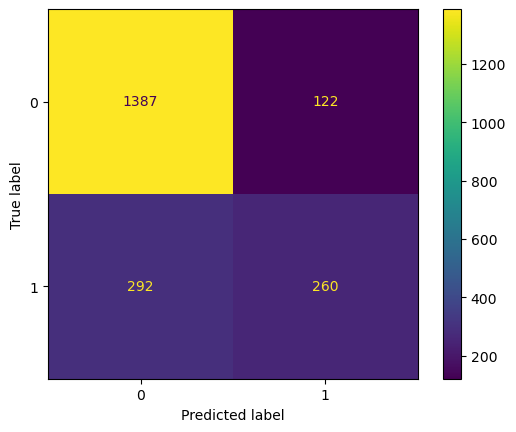

In [59]:
cm = confusion_matrix(y_test,y_pred)
dis = ConfusionMatrixDisplay(cm)
dis.plot()

In [60]:
import pickle 
with open('model.pkl','wb') as file:
    pickle.dump(model,file)
